In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
import matplotlib as mpl

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week16_densities_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [5]:
[ex for ex in experiments if len(ex['config']['data']['left_out_class_labels']) == 0][0]['result']

{'results': {'val_member_0_cross_entropy-val-0': [0.6442739367485046],
  'val_member_0_accuracy-val-0': [0.8285714387893677],
  'val_member_0_loss-val-0': [0.6442739367485046],
  'ensemble_accuracy-val-0': [0.8285714387893677],
  'accuracy_val__val': [0.8285714387893677],
  'accuracy_id_val__val': [0.8285714387893677],
  'accuracy_ood_val__val': [nan],
  'accuracy_val_no-edges_val': [0.7285714149475098],
  'accuracy_id_val_no-edges_val': [0.7285714149475098],
  'accuracy_ood_val_no-edges_val': [nan],
  'ece_val__val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.1588194572499722}],
  'ece_val_no-edges_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.02646612280181248}],
  'auroc_feature-distance_input-ber_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.8436957514846962}],
  'aucpr_feature-distance_input-ber_val': [{'py/object': 'numpy.float64',
    'dtype': 'float64',
    'value': 0.8470663801104851}],
 

In [6]:
collection = seml.database.get_collection(collection_name)
experiments_unfinished = [{'config' : r['config'], 'id' : r['_id']} for r in collection.find() if r['status'] not in ('COMPLETED',)]

In [7]:
set(ex['config']['model']['use_spectral_norm'] for ex in experiments_unfinished), \
    set(ex['config']['model']['residual'] for ex in experiments_unfinished)

({False}, {True})

In [8]:
mode = 'val' # 'test'

In [9]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
DENSITY_MODEL = 'Density Model'
EXPERIMENT = 'Experiment'

# Proxies / Density Model
STRUCTURE = 'Structure'
FEATURE_DISTANCE = 'Feature Distance'
INPUT_DISTANCE = 'Input Distance'
ENTROPY = 'Predictive Entropy'
MAX_SCORE = 'Max Score'
LOGIT_ENERGY = 'Logit Energy'
GPC = 'Gaussian Per Class'
MOG = 'Mixture of Gaussians'
NFPC = 'Normalizing Flow Per Class'
NF = 'Normalizing Flow'

# Fitting to
FIT_TO = 'Fit To'
FIT_TO_MASK = 'Labeled'
FIT_TO_ALL = 'All'
FIT_TO_CONF = 'High Conf.'

# NF types
FLOW_LAYER = 'Layer Type'
RADIAL = 'Radial'
MAF = 'MAF'
NUM_FLOW_LAYERS = 'Layers'
# aggregates info about layers
FLOW_MODEL = 'Flow Model'

# Covariance types
COVARIANCE_TYPE = 'Covariance'
FULL = 'Full'
DIAG = 'Diagonal'
ISO = 'Spherical'
EYE = 'Identity'

# Per class eval modes
PER_CLASS_MODE = 'Class Density'
WEIGHTED = 'Weighted'
MAX = 'Max'

RELATIVE = 'Background'

# MoG initializations
INITIALIZATION = 'Initialization'
RANDOM = 'Random'
PREDICTIONS = 'Predictions'

RELATIVE_YES = 'Relative'
RELATIVE_NO = 'Not Relative'

In [10]:
data = []


for ex in [ex for ex in experiments if not ex['config']['model']['residual'] and not ex['config']['model']['use_spectral_norm']]:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        
    }
    for k, vs in ex['metrics'].items():
        if ('auroc' in k or 'aucpr' in k) and k.endswith('_' + mode):
            if 'auroc' in k:
                metric = AUROC
                k = k.replace('auroc_', '')
            elif 'aucpr' in k:
                metric = AUCPR
                k = k.replace('aucpr_', '')
            else:
                raise ValueError(k)
            
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == 'feature-distance_input':
                metric_cfg[DENSITY_MODEL] = INPUT_DISTANCE
            elif k == 'structure':
                metric_cfg[DENSITY_MODEL] = STRUCTURE
            elif k == 'total-predictive-entropy':
                metric_cfg[DENSITY_MODEL] = ENTROPY
            elif k == 'max-score':
                metric_cfg[DENSITY_MODEL] = MAX_SCORE
            elif k == 'logit-energy':
                metric_cfg[DENSITY_MODEL] = LOGIT_ENERGY
            else:
                # These density models can be fit to different things
                if k.endswith('_fit-mask'):
                    metric_cfg[FIT_TO] = FIT_TO_MASK
                    k = k.replace('_fit-mask', '')
                elif k.endswith('_fit-all'):
                    metric_cfg[FIT_TO] = FIT_TO_ALL
                    k = k.replace('_fit-all', '')
                elif k.endswith('_fit-95conf'):
                    metric_cfg[FIT_TO] = FIT_TO_CONF
                    k = k.replace('_fit-95conf', '')
                else:
                    raise ValueError(k)
                if k == 'feature-distance':
                    metric_cfg[DENSITY_MODEL] = FEATURE_DISTANCE
                else:
                    if not k.endswith(':no'):
                        raise ValueError(k)
                    k = k.replace(':no', '')
                    
                    if k.startswith('gpc'):
                        _, covariance, gpc_mode, relative = k.split('-')
                        metric_cfg |= {
                            COVARIANCE_TYPE : {'diag' : DIAG, 'full' : FULL, 'iso' : ISO, 'eye' : EYE}[covariance],
                            PER_CLASS_MODE : {'mode:weighted' : WEIGHTED, 'mode:max' : MAX}[gpc_mode],
                            RELATIVE : {'relative:True' : RELATIVE_YES, 'relative:False' : RELATIVE_NO}[relative],
                            DENSITY_MODEL : GPC,
                        }
                    elif k.startswith('mog'):
                        _, components, covariance, initialization = k.split('-')
                        metric_cfg |= {
                            COVARIANCE_TYPE : {'diag' : DIAG, 'full' : FULL}[covariance],
                            INITIALIZATION : {'random' : RANDOM, 'predictions' : PREDICTIONS}[initialization],
                            DENSITY_MODEL : MOG,
                        }
                    elif k.startswith('nfpc'):
                        _, layers, layer_type, _, _, pc_mode, relative = k.split('-')
                        flow_layer = {'radial' : RADIAL, 'maf' : MAF}[layer_type]
                        metric_cfg |= {
                            FLOW_LAYER : flow_layer ,
                            NUM_FLOW_LAYERS : layers,
                            PER_CLASS_MODE : {'mode:weighted' : WEIGHTED, 'mode:max' : MAX}[pc_mode],
                            RELATIVE : {'relative:True' : RELATIVE_YES, 'relative:False' : RELATIVE_NO}[relative],
                            DENSITY_MODEL : NFPC,
                            FLOW_MODEL : f'{layers}-{flow_layer}',
                        }
                    elif k.startswith('nf'):
                        _, layers, layer_type, _, _ = k.split('-')
                        flow_layer = {'radial' : RADIAL, 'maf' : MAF}[layer_type]
                        metric_cfg |= {
                            FLOW_LAYER : flow_layer,
                            NUM_FLOW_LAYERS : layers,
                            DENSITY_MODEL : NF,
                            FLOW_MODEL : f'{layers}-{flow_layer}',
                        }
                    else:
                        raise ValueError(k)
                
                
            for v in vs:
                v = v['value']
                data.append({
                    metric : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base)




In [11]:
df = pd.DataFrame(data)

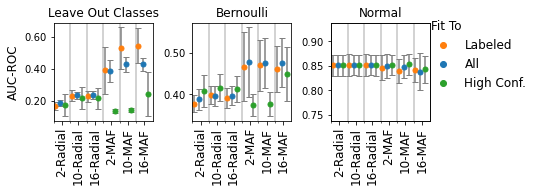

In [52]:
def plot_conditional_density(df, x, x_order, y, hue, hue_order, style, style_order,
                            hues = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red'],
                             styles = ['o', 'x', 'd'], fontsize=12,
                             legend_hue_bbox_to_anchor = (1.14, 0.95),
                             legend_style_bbox_to_anchor = (1.135, 0.6),
                             rows = True,
                            ):
    
    if rows:
        fig, axs = plt.subplots(2, 3, figsize=(7.6 * 0.9, 3.5 * 0.9), gridspec_kw = {
            #'width_ratios' : [0.8, 0.15, 0.06] * 2, 
            'wspace' : 0.4, 'hspace' : 0.2,
        }, sharey=False, sharex='col')
        rows = (RELATIVE_NO, RELATIVE_YES)
    else:
        fig, axs = plt.subplots(1, 3, figsize=(7.5 * 0.9, 2 * 0.9), gridspec_kw = {
            #'width_ratios' : [0.8, 0.15, 0.06] * 2, 
            'wspace' : 0.4, 'hspace' : 0.2,
        }, sharey=False, sharex='col', squeeze=False)
        rows = [None]
    
    if x_order is None:
        x_order = list(sorted(np.unique(df[x])))
    
    for col_idx, experiment in enumerate((LOC, BERNOULLI, NORMAL)):
        
        axs[0, col_idx].set_title(experiment, fontsize=fontsize)
        
        for row_idx, background in enumerate(rows):
            
            ax = axs[row_idx, col_idx]
            df_ax = df[(df[EXPERIMENT] == experiment)]
            if background is not None:
                df_ax = df_ax[df_ax[RELATIVE] == background]
            
            ax.set_xticks(np.arange(len(x_order)))
            ax.set_xticklabels(x_order, rotation=90, fontsize=fontsize)
            ax.set_xlim(-.5, len(x_order) - .5)
            
            if col_idx == 0: 
                ax.set_ylabel(y, fontsize=fontsize)
            if col_idx == axs.shape[1] - 1:
                ax2 = ax.twinx()
                ax2.set_ylabel(background, fontsize=fontsize, rotation=270, labelpad=15)
                ax2.set_yticks([])
                
                
            from matplotlib.ticker import FormatStrFormatter
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
            ax.set_xticks(np.arange(len(x_order)) - .5, minor=True)
            ax.grid(which='minor', color='lightgrey', axis='x', linestyle='-', linewidth=2)
            
            for x_pos, xx in enumerate(x_order):
                for hue_pos, hh in enumerate(hue_order):
                    
                    if style is None:
                        style_order = [None]
                    
                    for style_pos, ss in enumerate(style_order):
                        
                        df_hue_style = df_ax[(df_ax[x] == xx) & (df_ax[hue] == hh)]
                        if ss is not None:
                            df_hue_style = df_hue_style[(df_hue_style[style] == ss)]
                        ys = df_hue_style[y]
                        # Calculate the position: The interval in which to place all these is 1.0
                        pad = 0.05
                        hue_width = (1.0 - 2 * pad) / len(hue_order)
                        style_width = hue_width / len(style_order)
                        
                        pos = -.5 + 2 * pad + x_pos + hue_pos * hue_width + style_pos * style_width
                        
                        ax.errorbar([pos], [ys.mean()], [ys.std()], ecolor='grey', mew=1, 
                                    fmt=styles[style_pos], ms=5, capsize=3, c=hues[hue_pos])
                        
    # Dont make the resolution on an ax too small        
    for ax in axs.flatten():
        ax_tol = 0.1
        y_min, y_max = ax.get_ylim()
        mean = 0.5 * (y_min + y_max)
        ax.set_ylim(min(mean - ax_tol, y_min), max(y_max, mean + ax_tol))
            
    handles = []
    for hue_idx, hh in enumerate(hue_order):
        handles += [axs[-1, -1].scatter([], [], color=hues[hue_idx], marker='o')]

    legend_hue = fig.legend(handles, hue_order, title=hue, loc='upper right', 
                        bbox_to_anchor=legend_hue_bbox_to_anchor, frameon=False, fontsize=fontsize)
    plt.setp(legend_hue.get_title(), fontsize=fontsize)
    legend_hue._legend_box.align = "left"
    
    if style is not None:
        handles = []
        for style_idx, ss in enumerate(style_order):
            handles += [axs[-1, -1].scatter([], [], color='black', marker=styles[style_idx])]
        legend_style = fig.legend(handles, style_order, title=style, loc='upper right', 
                            bbox_to_anchor=legend_style_bbox_to_anchor, frameon=False, fontsize=fontsize)
        plt.setp(legend_style.get_title(), fontsize=fontsize)
        legend_style._legend_box.align = "left"
        
    return fig, axs

_ = plot_conditional_density(df[
    np.isfinite(df[AUROC]) &
    (df[NO_EDGES] == False) &
    (df[SETTING] == HYBRID) &
    (df[DENSITY_MODEL] == NF)
    
], FLOW_MODEL, 
            ['2-Radial', '10-Radial', '16-Radial', '2-MAF', '10-MAF', '16-MAF'], AUROC, FIT_TO, [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF], 
                                            None, [], rows=False,
                            
                            legend_hue_bbox_to_anchor = (1.12, 0.99),
                            legend_style_bbox_to_anchor = (1.13, 0.4))

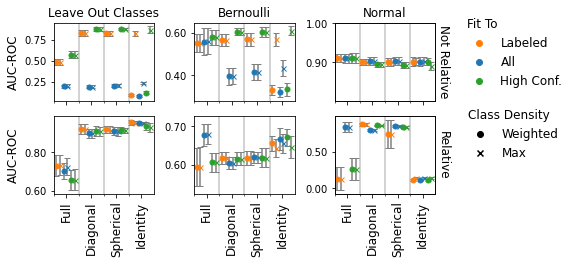

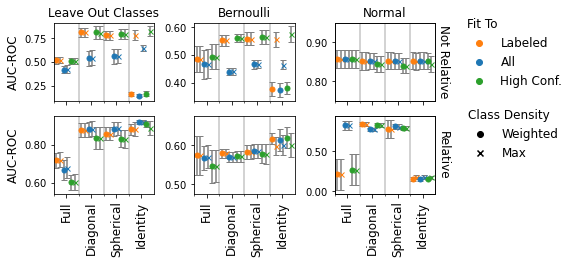

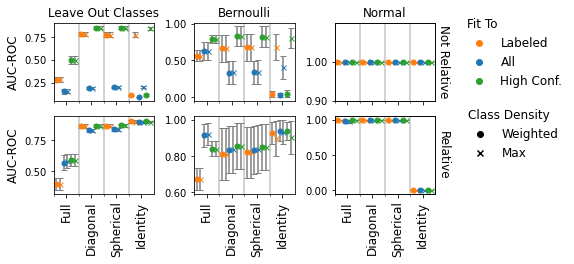

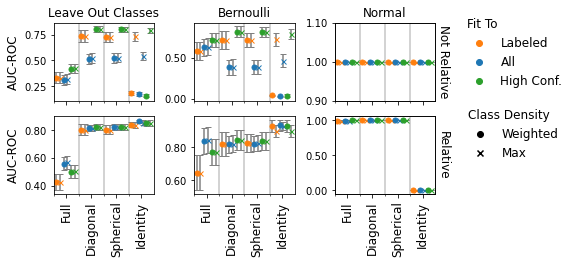

In [57]:
for no_edges, no_edge_suffix in ((False, ''), (True, '-no-edges')):
    for setting in (TRANSDUCTIVE, HYBRID):
        fig, axs = plot_conditional_density(df[
                np.isfinite(df[AUROC]) &
                (df[NO_EDGES] == no_edges) &
                (df[SETTING] == setting) &
                (df[DENSITY_MODEL] == GPC)

            ], COVARIANCE_TYPE, 
            [FULL, DIAG, ISO, EYE], AUROC, FIT_TO, [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF], 
                                            PER_CLASS_MODE, [WEIGHTED, MAX],
                             legend_hue_bbox_to_anchor = (1.18, 0.95),
                             legend_style_bbox_to_anchor = (1.173, 0.55),)
        path = f'thesis_nbs/density_models_plots/gpc-{setting.lower()}{no_edge_suffix}.pdf'
        plt.savefig(path, bbox_inches='tight')

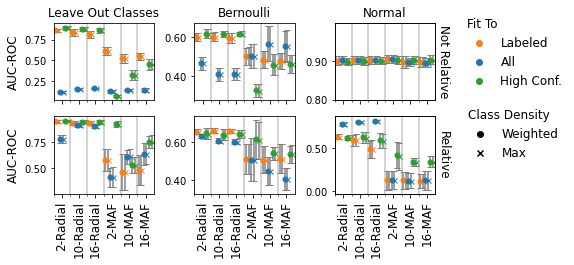

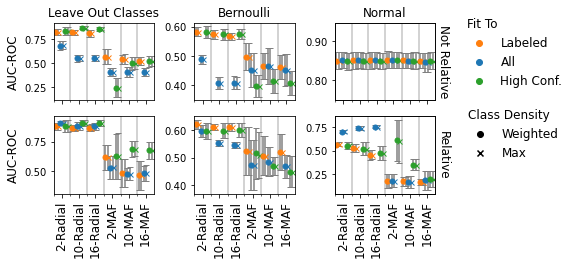

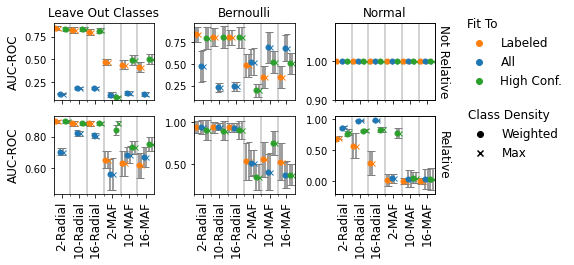

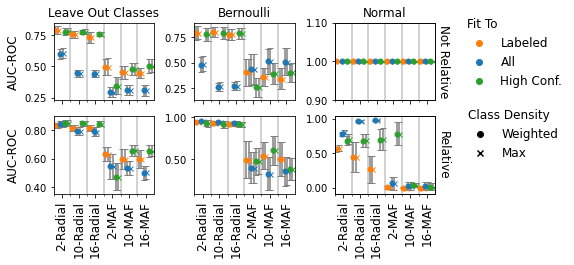

In [58]:
for no_edges, no_edge_suffix in ((False, ''), (True, '-no-edges')):
    for setting in (TRANSDUCTIVE, HYBRID):
        fig, axs = plot_conditional_density(df[
                np.isfinite(df[AUROC]) &
                (df[NO_EDGES] == no_edges) &
                (df[SETTING] == setting) &
                (df[DENSITY_MODEL] == NFPC)

            ], FLOW_MODEL, 
            ['2-Radial', '10-Radial', '16-Radial', '2-MAF', '10-MAF', '16-MAF'], AUROC, FIT_TO, [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF], 
                                            PER_CLASS_MODE, [WEIGHTED, MAX],
                             legend_hue_bbox_to_anchor = (1.18, 0.95),
                             legend_style_bbox_to_anchor = (1.173, 0.55),)
        path = f'thesis_nbs/density_models_plots/nfpc-{setting.lower()}{no_edge_suffix}.pdf'
        plt.savefig(path, bbox_inches='tight')

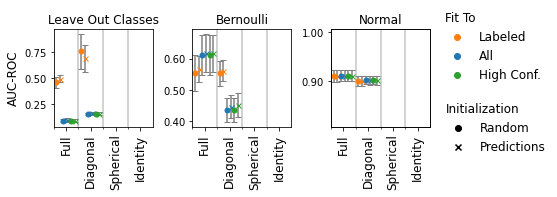

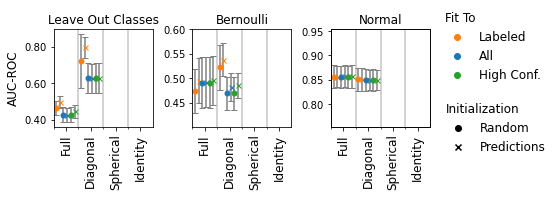

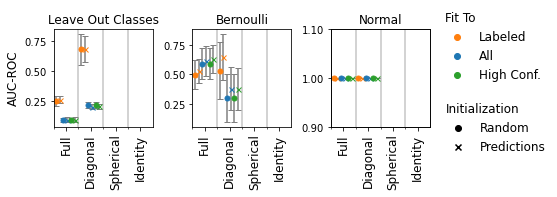

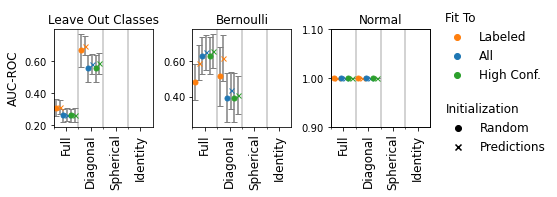

In [64]:
for no_edges, no_edge_suffix in ((False, ''), (True, '-no-edges')):
    for setting in (TRANSDUCTIVE, HYBRID):
        fig, axs = plot_conditional_density(df[
                np.isfinite(df[AUROC]) &
                (df[NO_EDGES] == no_edges) &
                (df[SETTING] == setting) &
                (df[DENSITY_MODEL] == MOG)

            ], COVARIANCE_TYPE, 
     [FULL, DIAG, ISO, EYE], 
     AUROC, FIT_TO, [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF], INITIALIZATION, [RANDOM, PREDICTIONS], rows=False,
                            
                            legend_hue_bbox_to_anchor = (1.15, 1.1),
                            legend_style_bbox_to_anchor = (1.16, 0.4))
        path = f'thesis_nbs/density_models_plots/mog-{setting.lower()}{no_edge_suffix}.pdf'
        plt.savefig(path, bbox_inches='tight')

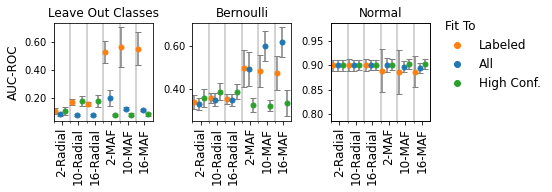

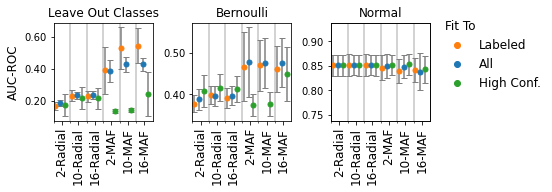

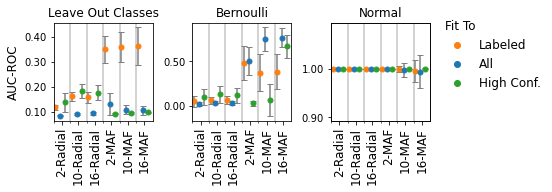

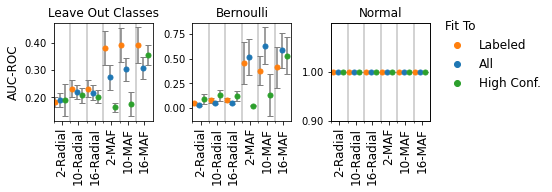

In [63]:
for no_edges, no_edge_suffix in ((False, ''), (True, '-no-edges')):
    for setting in (TRANSDUCTIVE, HYBRID):
        fig, axs = plot_conditional_density(df[
                np.isfinite(df[AUROC]) &
                (df[NO_EDGES] == no_edges) &
                (df[SETTING] == setting) &
                (df[DENSITY_MODEL] == NF)
    
], FLOW_MODEL, 
            ['2-Radial', '10-Radial', '16-Radial', '2-MAF', '10-MAF', '16-MAF'], AUROC, FIT_TO, [FIT_TO_MASK, FIT_TO_ALL, FIT_TO_CONF], 
                                            None, [], rows=False,
                            
                            legend_hue_bbox_to_anchor = (1.15, 0.99),
                            legend_style_bbox_to_anchor = (1.12, 0.4))
        path = f'thesis_nbs/density_models_plots/nf-{setting.lower()}{no_edge_suffix}.pdf'
        plt.savefig(path, bbox_inches='tight')